# Training & Evaluation of Content‑Based Autoencoder Beer Recommender

**Description:**  
This notebook loads the preprocessed beer content from `beer_content.csv`, transforms the aggregated review text into a 200‑feature TF‑IDF matrix, and defines a PyTorch autoencoder (inputDim=200, hiddenDim=512, embeddingDim=16) trained over 100 epochs with MSE loss and a learning‑rate scheduler. After evaluating reconstruction performance (MSE/RMSE), it extracts 16‑dimensional beer embeddings, performs sanity checks via cosine‑similarity comparisons and flavor‑profile queries, and saves the scripted model, embeddings tensor, and TF‑IDF vectorizer for downstream recommendation tasks.

---

## Overview

- **Data Source:**  
  `beer_content.csv` containing `beer_id`, `name`, and `all_text` with top‑N keywords per beer.

- **Objectives:**  
  1. Build a TF‑IDF feature matrix from cleaned beer text.  
  2. Train and validate an autoencoder to learn compact content embeddings.  
  3. Verify embedding quality with reconstruction metrics and manual sanity checks.  
  4. Export the trained model, embeddings, and vectorizer for inference.


## Load Preprocessed Beer Content Data

Load`beer_content.csv` into a pandas DataFrame `df`, prints the first few rows for inspection, and catches any exceptions if the file fails to load.


In [1]:
import pandas as pd

try:
    df = pd.read_csv('beer_content.csv')
    print("\final Data Sample:")
    print(df.head())
except Exception as e:
    print(f"Error loading reviews.csv: {e}")

inal Data Sample:
   beer_id               name  \
0        6           Turbodog   
1        7        Purple Haze   
2       10         Dubbel Ale   
3       17  Widmer Hefeweizen   
4       30     Trois Pistoles   

                                            all_text  
0  turbodog flavor flavors turbodog ale turbodog ...  
1  haze flavors haze flavor flavour haze haze bre...  
2  tasting dubbel dubbels flavored dubbel flavors...  
3  flavorful hefeweizens flavorful hefeweizen hef...  
4  beers trois brew trois breweries trois brews t...  


In [2]:
import torch

device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps"  if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using device: {device}")

if device.type == "cuda":
    idx = device.index or 0
    print("GPU name: ", torch.cuda.get_device_name(idx))
elif device.type == "mps":
    print("Running on Apple Silicon GPU via MPS")
else:
    print("Running on CPU")

Using device: mps
Running on Apple Silicon GPU via MPS


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   beer_id   500 non-null    int64 
 1   name      500 non-null    object
 2   all_text  500 non-null    object
dtypes: int64(1), object(2)
memory usage: 11.8+ KB


## Generate TF‑IDF Feature Matrix

Expands stop words with beer‑specific terms and applies a cleaning function before fitting a `TfidfVectorizer` (unigrams, `min_df=2`, `max_df=0.8`, `max_features=200`) to the beer text. After many iterations, we found that a feature range of 200–300 best balances expressiveness—>700 features caused embedding collapse (cosine similarity ≈99.99%), while too few features lost key tasting notes.


In [4]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS


non_taste_stop = {
    "us", "ca", "beer", "head", "taste", "pours", "like", "s", "t", "year", "round", "abv",'compared','10','11', '12',
    "availability", "yearround", "us","ca","just","really","overall","bottle","good", "nice", 'brewery',
    'brewing', 'brews', 'brew', 'style','drink', 'drinks', 'drinking', 'tastes', 'tasted', 'enjoy', 'enjoyable', 'okay',
    'recommended','appearance', 'looking','great', 'decent', 'pretty', 'amazing', 'excellent', 'best', 'favorite',
    'interesting', 'quality', 'look' 'beautiful', 'looks', 'look', 'exceptional', 'outstanding', 'slightly','expected',
    'definitely', 'pleasant', 'recommend', 'slightly', "awesome", "fantastic", "beautiful", "solid", "make", "review",
    'delightful','fine','quite','mix','makes','type','curious','liked','average','perfect','way','does','try','buy',
    'following','enjoyed','somewhat','definitely','wonderful','wonderfully','making','experience','specific','pure','odd',
    'impression','love', 'try', 'tried', 'extremely', 'alcoholic', 'appreciate', 'attractive', 'bad', 'better','compare',
    'especially', 'bold', 'characteristics', 'choice', 'color', 'colored','totally', 'unusual', 'usual', 'particular',
    'generally', 'different', 'drinker', 'finest', 'flavoring', 'flavours', 'kind','flavored', 'flavour', 
    'general', 'normal', 'opinion', 'pleasantly', 'prefer', 'regular','sample','gives','usually', 'brewed','honestly',
    'slight', 'smell', 'smells', 'smoothest', 'styles', 'traditional', 'typical', 'unique', 'worthy','breweries',
    'concerned', 'consider', 'considering', '12oz', '22oz', '2x', '750ml', '22','actually','absolutely', 'amazingly', 
    'exceptionally', 'extraordinary','fabulously', 'fantastically', 'incredibly', 'perfectly','remarkably', 'spectacular',
    'stunning', 'truly', 'totally','wonderfully', 'delightfully', 'deliciously', 'fascinating','exciting', 'fantastic',
    'disappointing','phenomenal','satisfying','enjoying','experienced', 'bottled', 'bottles', 'highly', 'surprisingly'
    'intriguing', 'noticeable', 'liking', 'lovely', 'impressed', 'impressive','intriguing', 'similar','remarkable',
    'reviewed','reviews', 'fairly','qualities','beautifully','drank','tastey', 'terrific','flavoured','surprisingly'
    'incredible','brewer','apparent','appealing', 'incredible', 'nicely', 'poured'
}

stopwords = ENGLISH_STOP_WORDS.union(non_taste_stop)


token_pattern = r'\b[a-z]{3,}\b'

def cleanText(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['clean_text'] = df['all_text'].apply(cleanText)
vectorizer = TfidfVectorizer(norm='l2', analyzer='word', ngram_range=(1,1), max_features=200, stop_words=list(stopwords),min_df=2, max_df=0.8)
tfidfMatrix = vectorizer.fit_transform(df['clean_text'])

print("Vocabulary size:", len(vectorizer.vocabulary_))
print("TF-IDF feature matrix shape:", tfidfMatrix.shape)


Vocabulary size: 200
TF-IDF feature matrix shape: (500, 200)


## Display Extracted TF‑IDF Features

Prints the list of TF‑IDF feature names selected by the vectorizer, revealing the keywords used as input features for the autoencoder.



In [5]:
print(vectorizer.get_feature_names_out())

['aged' 'alcohol' 'ale' 'ales' 'amber' 'ambers' 'american' 'apple'
 'apricot' 'aroma' 'aromas' 'astringent' 'banana' 'bananas' 'barleywine'
 'barleywines' 'beery' 'belgian' 'belgians' 'belgium' 'beverage' 'bitter'
 'bittering' 'bitterness' 'bitters' 'bittersweet' 'black' 'bland' 'blend'
 'blueberry' 'bock' 'bodied' 'booze' 'bourbon' 'bready' 'bright'
 'brooklyn' 'brown' 'budweiser' 'candied' 'cantillon' 'caramel'
 'caramelized' 'carbonation' 'champagne' 'cherry' 'chicory' 'chimay'
 'chocolate' 'chocolatey' 'chouffe' 'christmas' 'cinnamon' 'citrus'
 'citrusy' 'clear' 'cocoa' 'coffee' 'coors' 'coriander' 'cream'
 'creaminess' 'creamy' 'crisp' 'darker' 'delirium' 'dessert' 'distinctive'
 'doppelbock' 'dubbel' 'dubbels' 'espresso' 'feel' 'fermented' 'flanders'
 'flavourful' 'fresh' 'fruit' 'fruitiness' 'fruity' 'german' 'glass'
 'golden' 'grapefruit' 'gueuze' 'guinness' 'hazelnut' 'heavy' 'hefe'
 'hefeweizen' 'hefeweizens' 'heineken' 'hop' 'hopped' 'hoppier'
 'hoppiness' 'hoppy' 'hops' 'im

## Prepare Data for Autoencoder

Imports PyTorch and related utilities, converts the TF‑IDF matrix to a dense NumPy array, performs an 80/20 train‑validation split, and wraps the resulting arrays as PyTorch tensors (`XTrain`, `XVal`).


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

X = tfidfMatrix.toarray()

XTrainNp, XValNp = train_test_split(X, test_size=0.2, random_state=42)
XTrain = torch.tensor(XTrainNp, dtype=torch.float)
XVal = torch.tensor(XValNp, dtype=torch.float)

## Create PyTorch Dataset and DataLoaders

Defines a `BeerDataset` class for wrapping feature tensors, then instantiates training and validation datasets and creates `DataLoader`s (batch size 32, shuffled for training, sequential for validation).


In [7]:
class BeerDataset(Dataset):
    def __init__(self, features):
        self.features = features
        
    def __len__(self):
        return self.features.size(0)
    
    def __getitem__(self, idx):
        return self.features[idx]

trainDataset = BeerDataset(XTrain)
valDataset = BeerDataset(XVal)

trainLoader = DataLoader(trainDataset, batch_size=32, shuffle=True)
valLoader = DataLoader(valDataset, batch_size=32, shuffle=False)

## Define Autoencoder and Training Setup

The `BeerAutoencoder` class is defined with an encoder (input→hidden→embedding) and decoder (embedding→hidden→output with sigmoid). A model instance is moved to `device`, and training components are configured: MSE loss, Adam optimizer (lr=1e-3, weight_decay=1e-5), and a ReduceLROnPlateau learning‑rate scheduler.

`BeerAutoencoder` is instantiated with `inputDim=len(vectorizer.vocabulary_)` (200 features), `hiddenDim=512`, and `embeddingDim=16`—a configuration determined via extensive experimentation on hidden/embedding dimensions and feature counts that balanced reconstruction quality and cosine similarity variance.



In [8]:
class BeerAutoencoder(nn.Module):
    def __init__(self, inputDim=500, hiddenDim=256, embeddingDim=32):
        super(BeerAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(inputDim, hiddenDim),
            nn.ReLU(),
            nn.Linear(hiddenDim, embeddingDim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(embeddingDim, hiddenDim),
            nn.ReLU(),
            nn.Linear(hiddenDim, inputDim),
            nn.Sigmoid()  # Output values between 0 and 1
        )
    
    def forward(self, x):
        embedding = self.encoder(x)
        reconstruction = self.decoder(embedding)
        return reconstruction, embedding

model = BeerAutoencoder(inputDim=len(vectorizer.vocabulary_), hiddenDim=512, embeddingDim=16)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                       mode='min', 
                                                       factor=0.5, 
                                                       patience=5)

## Train Autoencoder and Plot Loss

Runs a 100‑epoch training loop that computes MSE reconstruction loss on each batch, backpropagates gradients, updates model parameters, records the average loss per epoch, and adjusts the learning rate via the ReduceLROnPlateau scheduler. Concludes by plotting the epoch‑wise training loss curve with matplotlib to assess convergence.


Epoch 1/100, Loss: 0.1874
           → current LR: 0.00100
Epoch 2/100, Loss: 0.0399
           → current LR: 0.00100
Epoch 3/100, Loss: 0.0049
           → current LR: 0.00100
Epoch 4/100, Loss: 0.0048
           → current LR: 0.00100
Epoch 5/100, Loss: 0.0048
           → current LR: 0.00100
Epoch 6/100, Loss: 0.0047
           → current LR: 0.00100
Epoch 7/100, Loss: 0.0047
           → current LR: 0.00100
Epoch 8/100, Loss: 0.0046
           → current LR: 0.00100
Epoch 9/100, Loss: 0.0046
           → current LR: 0.00100
Epoch 10/100, Loss: 0.0046
           → current LR: 0.00100
Epoch 11/100, Loss: 0.0045
           → current LR: 0.00100
Epoch 12/100, Loss: 0.0045
           → current LR: 0.00100
Epoch 13/100, Loss: 0.0045
           → current LR: 0.00100
Epoch 14/100, Loss: 0.0043
           → current LR: 0.00100
Epoch 15/100, Loss: 0.0042
           → current LR: 0.00100
Epoch 16/100, Loss: 0.0040
           → current LR: 0.00100
Epoch 17/100, Loss: 0.0038
           → current L

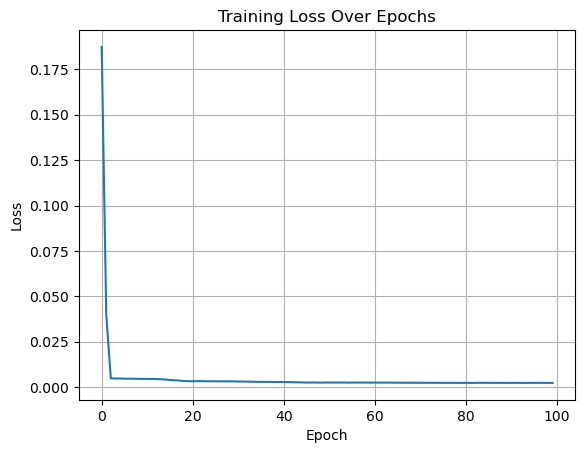

In [9]:
epochs = 100
losses = [] #added to store avg loss per epoch

for epoch in range(epochs):
    model.train()
    totalLoss = 0.0
    for batch in trainLoader:
        optimizer.zero_grad()
        batch = batch.to(device)
        reconstruction, _ = model(batch)
        loss = criterion(reconstruction, batch)
        loss.backward()
        optimizer.step()
        totalLoss += loss.item()
        
    avgLoss = totalLoss / len(trainLoader)
    losses.append(avgLoss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avgLoss:.4f}")

    scheduler.step(avgLoss)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"           → current LR: {current_lr:.5f}")

#for visualising the losses
import matplotlib.pyplot as plt

plt.plot(losses)
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

## Validate Autoencoder Performance

Switch to evaluation mode, computes batch-wise reconstruction MSE on the validation set without gradients, aggregates losses to calculate average MSE and RMSE, and prints the metrics.


In [10]:
# Validate the model
model.eval()
valLoss = 0.0
with torch.no_grad():
    for batch in valLoader:
        batch = batch.to(device)
        reconstruction, _ = model(batch)
        loss = criterion(reconstruction, batch)
        valLoss += loss.item() * batch.size(0)
        
avgValLoss = valLoss / len(valDataset)
rmse = avgValLoss ** 0.5
print(f"Validation MSE: {avgValLoss:.4f}")
print(f"Validation RMSE: {rmse:.4f}")

Validation MSE: 0.0029
Validation RMSE: 0.0535


## Sanity Check Utilities

- Computes embeddings for all beers and stores them in `beerEmbeddings`  
- `getBeerDetailsByIndex(beerIndex)`: prints the beer’s ID and name  
- `getBeersDetailsByIndices(beerIndices, similarity)`: lists beers with their cosine similarity scores  
- `getTopKSimilarBeersByIndex(beerIndex, topK)`: retrieves and displays the top‑K similar beers by index  
- `getTopKSimilarBeersByQuery(query, topK)`: transforms a text query into an embedding and displays the top‑K similar beers  


In [11]:
# utility methods
XTensor = torch.tensor(X, dtype=torch.float).to(device)
model.eval()
with torch.no_grad():
    _, beerEmbeddings = model(XTensor)  # Obtain embeddings for all beers, shape: (500, 16)

def getBeerDetailsByIndex(beerIndex):
    beer_id = df.iloc[beerIndex]['beer_id']
    name = df.iloc[beerIndex]['name']
    print("Beer ID:", beer_id, "Name:", name)

def getBeersDetailsByIndices(beerIndices,similarity):
    for index in beerIndices:
        beer_id = df.iloc[index.item()]['beer_id']
        name    = df.iloc[index.item()]['name']
        print(f"{beer_id:5d} | {name:30s} | simlarity={similarity[index.item()]:.3f}")


def getTopKSimilarBeersByIndex(beerIndex, topK):
    targetEmbedding = beerEmbeddings[beerIndex].unsqueeze(0)
    cosSim = F.cosine_similarity(targetEmbedding, beerEmbeddings)
    cosSim[beerIndex] = -1
    _, topIndices = torch.topk(cosSim, k=topK)
    getBeerDetailsByIndex(beerIndex)
    getBeersDetailsByIndices(topIndices,cosSim)
    return topIndices

def getTopKSimilarBeersByQuery(query, topK):
    queryClean = cleanText(query)
    queryTfidf = vectorizer.transform([queryClean])
    queryTensor = torch.tensor(queryTfidf.toarray(), dtype=torch.float).to(device)

    model.eval()
    with torch.no_grad():
        _, queryEmbedding = model(queryTensor)
    similarity = F.cosine_similarity(queryEmbedding, beerEmbeddings)
    _, topIndicesTensor = torch.topk(similarity, topK)
    getBeersDetailsByIndices(topIndicesTensor, similarity)
    return topIndicesTensor


## Inspect Full Cosine Similarity Distribution

Calls `getTopKSimilarBeersByIndex(112, 500)` to compute and display cosine similarities between beer index 112 and all 500 beers, printing the full range of similarity scores for a comprehensive sanity check. Upon visual inspection, the highest‑scoring beers clearly share meaningful flavor‑profile similarities with the target, while the lowest‑scoring beers are appropriately dissimilar.  


In [12]:
# finding similar beer based on beer -> passed sanity check
getTopKSimilarBeersByIndex(110,500)

Beer ID: 680 Name: Brooklyn Black Chocolate Stout
49286 | Mokah                          | simlarity=1.000
  283 | Sierra Nevada Stout            | simlarity=1.000
94350 | Bomb!                          | simlarity=1.000
52128 | Java Head Stout                | simlarity=1.000
 3434 | Milk Stout                     | simlarity=1.000
37265 | Black Note Stout               | simlarity=1.000
 1117 | Kalamazoo Stout                | simlarity=1.000
41626 | Double Stout                   | simlarity=1.000
 8023 | Siberian Night Imperial Stout  | simlarity=1.000
 1013 | Storm King Stout               | simlarity=1.000
 1658 | Big Bear Black Stout           | simlarity=1.000
34483 | Ten FIDY                       | simlarity=1.000
 2403 | Double Cream Stout             | simlarity=1.000
46987 | Beer Geek Brunch Weasel        | simlarity=1.000
  703 | Murphy's Irish Stout           | simlarity=1.000
  356 | Imperial Stout                 | simlarity=1.000
47360 | Samuel Adams Imperial Stout   

tensor([458,  60, 496, 464, 258, 412, 153, 427, 302, 146, 201, 398, 240, 444,
        114,  66, 446, 494, 448, 325, 298, 397, 182, 346, 347, 342,  76, 345,
         37, 154, 152, 317, 128, 394, 436, 216, 264, 348, 388, 391, 239, 351,
        386, 481, 473, 178, 445,  39,  84,  13, 429, 135, 242, 439, 320, 313,
        103, 416, 357, 425,  96, 122, 433, 477, 461, 392, 375, 355, 423, 208,
        229, 424, 275, 304, 123, 327, 316, 383, 222, 323, 428, 189, 396, 455,
        432, 333, 296, 475, 130,  47, 277,  45, 233,   2, 213, 414, 119, 207,
         16, 133, 370,  64, 265, 101, 106, 138, 246,  97,  85, 312, 389, 295,
        364, 118, 102, 194, 109, 281, 221, 262, 168, 173,  40, 401, 431,  10,
        352, 107,  79, 198, 331,  49,  43,  59,  27, 440, 156, 170,  24, 254,
          9, 179, 454, 212, 166, 223, 273, 117, 241, 209, 124, 256, 148, 104,
        125, 243, 143, 227, 292,  12, 132, 310, 406, 235,  56, 404, 358,  90,
        197, 127, 120, 402, 167,   3,  93, 422,  26, 269, 180, 3

## Execute Sanity‑Check Query Suite

A set of eleven representative flavor‑profile queries (e.g., “imperial stout roasted chocolate espresso,” “ipa juicy citrus piney,” “raspberry sour tart lemon”) is defined in `SANITY_QUERIES`. Loops over each query and invokes `getTopKSimilarBeersByQuery(query, topK=15)` to list the top 15 recommendations. Visual inspection confirmed that the returned beers closely match the intended flavor profiles, validating the model’s ability to surface genuinely similar and dissimilar beers.  


In [13]:
SANITY_QUERIES = {
    "q1":  "imperial stout roasted chocolate espresso",
    "q2":  "ipa juicy citrus piney",
    "q3":  "hefeweizen german",
    "q4":  "belgian tripel apricot spicy vanilla",
    "q5":  "pumpkin cinnamon vanilla",
    "q6":  "smoked porter coffee cocoa roast",
    "q7":  "raspberry sour tart lemon",
    "q8":  "bourbon barrel aged stout roasty malty",
    "q9":  "roasty malty smooth",
    "q10": "pilsner pale citrus lemon",
    "q11": "heineken lager",
}

# finding similar beer based on beer -> passed sanity check
for style, query in SANITY_QUERIES.items():
    print(f"recommendations for: {query}")
    getTopKSimilarBeersByQuery(query, topK=15)
    print('')


recommendations for: imperial stout roasted chocolate espresso
  754 | Guinness Draught               | simlarity=0.999
41702 | Theobroma                      | simlarity=0.999
16062 | Brewer's Reserve Bourbon Barrel Stout | simlarity=0.999
 2010 | Java Stout                     | simlarity=0.998
 8322 | New Holland The Poet           | simlarity=0.998
14309 | Samuel Adams Chocolate Bock    | simlarity=0.998
10672 | Bourbon County Brand Stout     | simlarity=0.998
 5428 | Dragon's Milk                  | simlarity=0.997
40058 | Choklat (Blackwater Series)    | simlarity=0.997
43670 | Bourbon Barrel Quad Barrel-Aged Ale (BBQ) | simlarity=0.994
16909 | Curieux                        | simlarity=0.994
28877 | Beer Geek Breakfast            | simlarity=0.993
30764 | Coffee Bender                  | simlarity=0.992
50176 | Chocolate Oak Aged Yeti        | simlarity=0.992
  224 | Schneider Weisse Tap 6 Unser Aventinus | simlarity=0.991

recommendations for: ipa juicy citrus piney
 3158 | Hop

## Save Trained Autoencoder Model

Sets the model to evaluation mode, uses TorchScript to script (freeze) the autoencoder into `scripted_model`, and saves it as `beer_autoencoder_frozen.pt` for efficient deployment and later inference.


In [14]:
# save trained model
model.eval()
scripted_model = torch.jit.script(model)
scripted_model.save("beer_autoencoder_frozen.pt")

## Save Beer Embeddings

Moves the `beerEmbeddings` tensor to CPU and persists it to `beer_embeddings_autoencoder.pt` using `torch.save` for downstream recommendation inference.


In [15]:
# save trained beer autoencoder
beerEmbeddings = beerEmbeddings.cpu()       # move to CPU if on GPU/MPS
torch.save(beerEmbeddings, "beer_embeddings_autoencoder.pt")

## Save TF‑IDF Vectorizer

Pickles the trained `vectorizer` to `tfidf_vectorizer.pkl` for later reuse in transforming text inputs during inference.  


In [16]:
import pickle

with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)